In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse 
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf

all_time =30
Time = 40
neuron_num = 85
datax = scipy.io.loadmat("spike85_k09_6000.mat")
y_data = datax["spike85_k09_6000"][:,:all_time].T
traj = scipy.io.loadmat("trj85_k09_6000.mat")
traj = traj["trj85_k09_6000"][:,:all_time].T
latent_dim = 2

inp = tf.random.normal([all_time, 0, 1])
gru = tf.keras.layers.GRU(4)
outp = gru(inp)
    
def sampling(args):
    z_mean, z_logvar = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), seed = 5) # ε
    return z_mean + K.exp(0.5 * z_logvar) * epsilon

inputs = Input(shape=neuron_num)
x1 = Dense(256, activation='relu')(inputs)  
x2 = Dense(64, activation='relu')(x1) 
z_mean = Dense(latent_dim)(x2)
z_logvar = Dense(latent_dim)(x2)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logvar])
encoder = Model(inputs, [z_mean, z_logvar, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,))
x3 = Dense(64, activation='relu')(latent_inputs)  
x4 = Dense(256, activation='relu')(x3)  
outputs = Dense(neuron_num, activation='linear')(x4)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

z_output = encoder(inputs)[2]
outputs = decoder(z_output)
vae = Model(inputs, outputs, name='variational_autoencoder')

kl_loss = 1 + z_logvar - K.square(z_mean) - K.exp(z_logvar)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0#-0.5

reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= neuron_num

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(y_data,epochs=1500,batch_size=1)

In [1]:
import matplotlib.cm as cm
def plot_results(encoder,
                 decoder,
                 x_test,
                 batch_size=1,
                 model_name="vae_mnist"):
    z_mean, _, _ = encoder.predict(x_test,batch_size=128)
    plt.figure(figsize=(12, 5))
    plt.plot(z_mean[:, 0])
    plt.plot(z_mean[:, 1])
    plt.show()

plot_results(encoder,decoder,y_data,batch_size=128, model_name="vae_mlp")

NameError: name 'encoder' is not defined

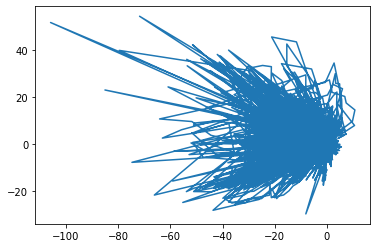

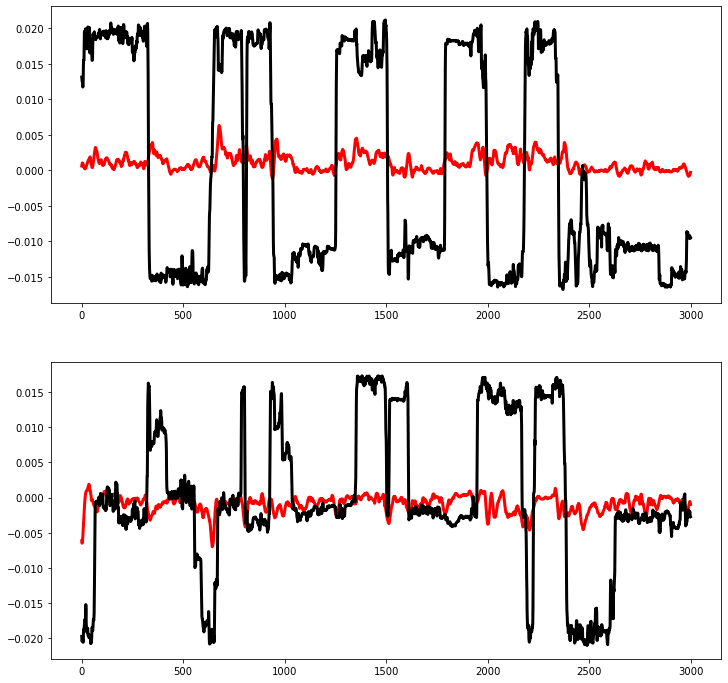

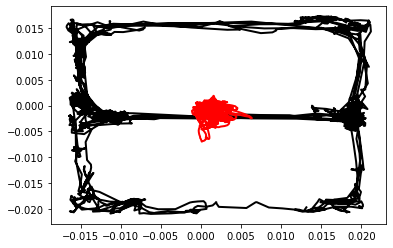

In [3]:
qz_mean_est, _, _ = encoder.predict(y_data)

plt.plot(qz_mean_est[:,0],qz_mean_est[:,1])
qz_est_c = qz_mean_est - qz_mean_est.mean(axis=0)
qz_est_norm = qz_est_c#/np.linalg.norm(qz_est_c)
qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
import funs
z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)
from scipy import signal
qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
fig = plt.figure(figsize=(12,12))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')